# LSTM vs RNN
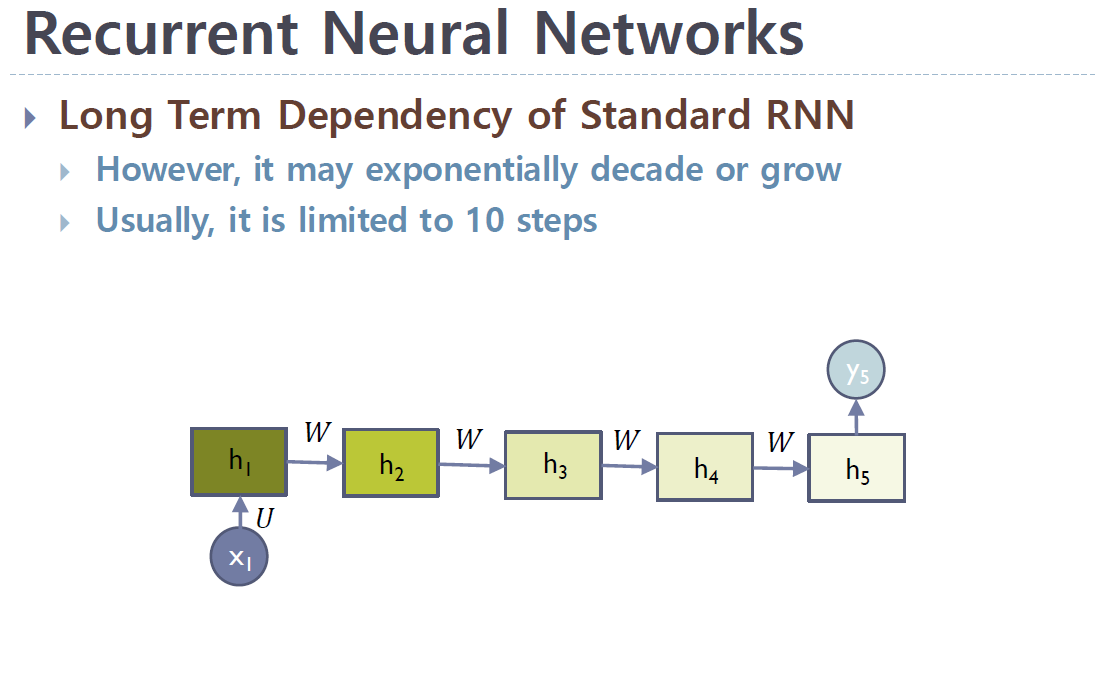

### RNN을 사용할 때, timestep이 너무 길어진다면 과거의 정보를 잃는 현상이 생긴다!

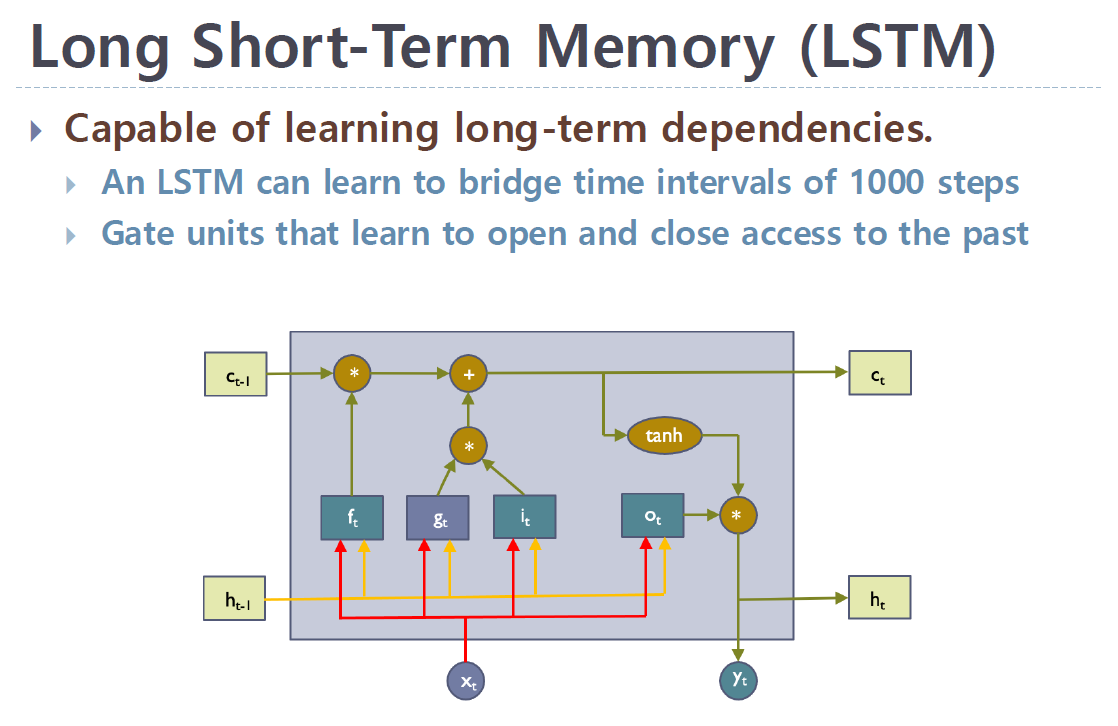

###하지만 LSTM은 과거의 정보를 "보존"하는 path가 존재하여 그 경향을 낮출 수 있다

In [9]:
import os, tarfile, urllib.request, time, math, random, re
import torch, torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device :", device)

Device : cuda


In [10]:
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_ROOT = "/content/aclImdb"
TGZ_PATH  = "/content/aclImdb_v1.tar.gz"

if not os.path.exists(DATA_ROOT):
    print(">> 다운로드 중...")
    urllib.request.urlretrieve(URL, TGZ_PATH)
    with tarfile.open(TGZ_PATH, "r:gz") as tar:
        tar.extractall(path="/content")
    print("   압축 해제 완료.")

def read_imdb(split):
    data, labels = [], []
    for label in ("pos", "neg"):
        dir_path = os.path.join(DATA_ROOT, split, label)
        for fname in os.listdir(dir_path):
            with open(os.path.join(dir_path, fname), encoding="utf-8") as f:
                text = f.read().strip()
            data.append(text)
            labels.append(1 if label == "pos" else 0)
    return data, labels

train_texts, train_labels = read_imdb("train")
test_texts,  test_labels  = read_imdb("test")

print(f"Train size: {len(train_texts)}, Test size: {len(test_texts)}")

>> 다운로드 중...
   압축 해제 완료.


In [11]:
def tokenize(text):
    return re.findall(r"[A-Za-z0-9]+", text.lower())

from collections import Counter
MAX_VOCAB = 30_000
counter = Counter()
for t in train_texts:
    counter.update(tokenize(t))

vocab = {"<pad>":0, "<unk>":1}
for tok, _ in counter.most_common(MAX_VOCAB):
    vocab[tok] = len(vocab)

pad_idx, unk_idx = vocab["<pad>"], vocab["<unk>"]

def encode(text):
    return [vocab.get(tok, unk_idx) for tok in tokenize(text)]

In [12]:
def collate(batch):
    lab, seq, length = [], [], []
    for y, x in batch:
        ids = torch.tensor(encode(x), dtype=torch.long)
        seq.append(ids)
        length.append(ids.size(0))
        lab.append(y)
    seq = nn.utils.rnn.pad_sequence(seq, batch_first=True, padding_value=pad_idx)
    return torch.tensor(lab), seq, torch.tensor(length)

In [33]:
BATCH = 128
train_data = list(zip(train_labels, train_texts))
test_data  = list(zip(test_labels,  test_texts))

random.shuffle(train_data)                      # 섞기
train_dl = DataLoader(train_data, batch_size=BATCH, shuffle=True,  collate_fn=collate)
test_dl  = DataLoader(test_data,  batch_size=BATCH, shuffle=False, collate_fn=collate)

In [14]:
class SeqClassifier(nn.Module):
    def __init__(self, rnn_type="RNN", emb_dim=128, hidden=128, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), emb_dim, padding_idx=pad_idx)
        RNNLayer = nn.RNN if rnn_type=="RNN" else nn.LSTM
        self.rnn = RNNLayer(emb_dim, hidden, num_layers=1, batch_first=True)
        self.fc  = nn.Linear(hidden, 1)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, h = self.rnn(x)
        if isinstance(self.rnn, nn.LSTM):
            h = h[0]                     # (h_n, c_n)
        logit = self.fc(h.squeeze(0))    # [B, 1]
        return logit.squeeze(1)

In [15]:
def train_epoch(model, loader, crit, opt):
    model.train(); tot, cor, loss_sum, t0 = 0,0,0.0,time.time()
    for y,x,l in loader:
        y,x,l = y.to(device), x.to(device), l.to(device)
        opt.zero_grad()
        out = model(x,l)
        loss = crit(out, y.float())
        loss.backward(); opt.step()
        loss_sum += loss.item()*y.size(0)
        cor += ((out>0).long()==y).sum().item(); tot += y.size(0)
    return loss_sum/tot, cor/tot, time.time()-t0

In [16]:
@torch.no_grad()
def evaluate(model, loader, crit):
    model.eval(); tot, cor, loss_sum = 0,0,0.0
    for y,x,l in loader:
        y,x,l = y.to(device), x.to(device), l.to(device)
        out = model(x,l)
        loss = crit(out, y.float())
        loss_sum += loss.item()*y.size(0)
        cor += ((out>0).long()==y).sum().item(); tot += y.size(0)
    return loss_sum/tot, cor/tot

In [17]:
def run(model_type):
    model = SeqClassifier(model_type).to(device)
    print(f"\n▶ {model_type} 파라미터: {sum(p.numel() for p in model.parameters())/1e6:.2f} M")
    crit = nn.BCEWithLogitsLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=1e-3)
    EPOCH = 5
    for ep in range(1,EPOCH+1):
        tr_l, tr_a, sec = train_epoch(model, train_dl, crit, opt)
        te_l, te_a      = evaluate(model, test_dl,  crit)
        print(f"[{model_type}] Ep{ep:02d} | "
              f"Train Acc {tr_a:.4f} | Test Acc {te_a:.4f} | "
              f"Loss {tr_l:.4f} | {sec:.1f}s")
    return model


In [21]:
@torch.no_grad()
def show_predictions(model, dataset, n_show=10):
    model.eval()
    for i, (y_true, text) in enumerate(dataset[:n_show]):
        ids     = torch.tensor(encode(text), dtype=torch.long).unsqueeze(0).to(device)
        length  = torch.tensor([ids.size(1)]).to(device)
        logit   = model(ids, length)
        y_pred  = int((logit > 0).item())        # sigmoid 없이 바로 >0
        snippet = " ".join(tokenize(text)[:25])  # 앞 25단어만 표시
        print(f"[{i:02d}]   예측:{y_pred}  실제:{y_true}  ── {snippet} ...")

In [18]:
rnn_model  = run("RNN")


▶ RNN 파라미터: 3.87 M
[RNN] Ep01 | Train Acc 0.5831 | Test Acc 0.5921 | Loss 0.6722 | 13.4s
[RNN] Ep02 | Train Acc 0.6490 | Test Acc 0.6918 | Loss 0.6177 | 11.7s
[RNN] Ep03 | Train Acc 0.6148 | Test Acc 0.6113 | Loss 0.6511 | 11.9s
[RNN] Ep04 | Train Acc 0.6837 | Test Acc 0.6694 | Loss 0.5880 | 11.7s
[RNN] Ep05 | Train Acc 0.7625 | Test Acc 0.6984 | Loss 0.4957 | 12.5s


In [19]:
lstm_model = run("LSTM")


▶ LSTM 파라미터: 3.97 M
[LSTM] Ep01 | Train Acc 0.6645 | Test Acc 0.7166 | Loss 0.5984 | 12.7s
[LSTM] Ep02 | Train Acc 0.7731 | Test Acc 0.7952 | Loss 0.4800 | 12.8s
[LSTM] Ep03 | Train Acc 0.8251 | Test Acc 0.8208 | Loss 0.4012 | 12.7s
[LSTM] Ep04 | Train Acc 0.7943 | Test Acc 0.7052 | Loss 0.4370 | 12.4s
[LSTM] Ep05 | Train Acc 0.8532 | Test Acc 0.8306 | Loss 0.3474 | 12.4s


In [34]:
random.shuffle(test_data)
# RNN 예측 살펴보기
print("\n=== RNN 결과 샘플 ===")
show_predictions(rnn_model, test_data, n_show=10)


=== RNN 결과 샘플 ===
[00]   예측:1  실제:1  ── i don t understand why critics would bash this movie it s a teen movie that s actually serious which is a rarity i ll ...
[01]   예측:1  실제:0  ── kennan ivory wayans was so funny in low down dirty shame that i had to see this one and it was one of the worst ...
[02]   예측:1  실제:1  ── i found it charming nobody else but kiarostami can do so little and yet get so much you might think i m weird but i ...
[03]   예측:0  실제:0  ── a cryptozoologist captures a mythical chupacabra on a caribbean island to get it back to civilization he bribes his way onto the cargo bay of ...
[04]   예측:0  실제:0  ── after watching caddyshack 1 i d heard there was a sequel and decided to look it up the movie seemed pretty bad and i told ...
[05]   예측:1  실제:0  ── an excellent cast who do their best with an awful script inept direction and some of the worst score that i have ever heard more ...
[06]   예측:0  실제:1  ── broadcast news opens with a series of brief vignettes that are a

In [35]:
# LSTM 예측 살펴보기
print("\n=== LSTM 결과 샘플 ===")
show_predictions(lstm_model, test_data, n_show=30)


=== LSTM 결과 샘플 ===
[00]   예측:1  실제:1  ── i don t understand why critics would bash this movie it s a teen movie that s actually serious which is a rarity i ll ...
[01]   예측:0  실제:0  ── kennan ivory wayans was so funny in low down dirty shame that i had to see this one and it was one of the worst ...
[02]   예측:1  실제:1  ── i found it charming nobody else but kiarostami can do so little and yet get so much you might think i m weird but i ...
[03]   예측:0  실제:0  ── a cryptozoologist captures a mythical chupacabra on a caribbean island to get it back to civilization he bribes his way onto the cargo bay of ...
[04]   예측:0  실제:0  ── after watching caddyshack 1 i d heard there was a sequel and decided to look it up the movie seemed pretty bad and i told ...
[05]   예측:0  실제:0  ── an excellent cast who do their best with an awful script inept direction and some of the worst score that i have ever heard more ...
[06]   예측:0  실제:1  ── broadcast news opens with a series of brief vignettes that are 